# Non-linear Modeling
### In the lab for this chapter we will analyse the $\texttt{Wage}$ data set through the use of models which will try to capture non-linear relationships between the response and the predictors.

In [2]:
# import the relevant libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from patsy import dmatrix

In [3]:
# import and inspect the data
Wage = pd.read_csv('Wage.csv', header=0, na_values='NA')
print("Shape of data set:\n", Wage.shape)
print(Wage.head())

Shape of data set:
 (3000, 11)
   year  age            maritl      race        education              region  \
0  2006   18  1. Never Married  1. White     1. < HS Grad  2. Middle Atlantic   
1  2004   24  1. Never Married  1. White  4. College Grad  2. Middle Atlantic   
2  2003   45        2. Married  1. White  3. Some College  2. Middle Atlantic   
3  2003   43        2. Married  3. Asian  4. College Grad  2. Middle Atlantic   
4  2005   50       4. Divorced  1. White       2. HS Grad  2. Middle Atlantic   

         jobclass          health health_ins   logwage        wage  
0   1. Industrial       1. <=Good      2. No  4.318063   75.043154  
1  2. Information  2. >=Very Good      2. No  4.255273   70.476020  
2   1. Industrial       1. <=Good     1. Yes  4.875061  130.982177  
3  2. Information  2. >=Very Good     1. Yes  5.041393  154.685293  
4  2. Information       1. <=Good     1. Yes  4.318063   75.043154  


### The data consists of entries describing the wages of separate individuals along with features which are thought to be relevsant to that quantity, e.g., the year when the data was recorded, the age of the worker, their education, and so on. We check whether there are any missing values in the data.

In [4]:
print(Wage.isnull().sum())

year          0
age           0
maritl        0
race          0
education     0
region        0
jobclass      0
health        0
health_ins    0
logwage       0
wage          0
dtype: int64


### There seem to be no missing values in the data.
## 1. Polynomial Regression and Step Functions
### We now perform simple polynomial regression on the data, trying to predict the wage of a given individual solely based on their age. We consider first fitting a fourth-order polynomial.

In [5]:
X = Wage.age.values.reshape(Wage.shape[0], 1)
y = Wage.wage.values.reshape(Wage.shape[0], 1)
print("Age:", X)
print("Wage:", y)


Age: [[18]
 [24]
 [45]
 ...
 [27]
 [27]
 [55]]
Wage: [[ 75.04315402]
 [ 70.47601965]
 [130.98217738]
 ...
 [ 66.22940829]
 [ 87.98103279]
 [ 90.48191336]]


In [6]:
n_deg = 4
polynomial_features = PolynomialFeatures(degree=n_deg)
X_poly = polynomial_features.fit_transform(X)
print(X_poly)

[[1.000000e+00 1.800000e+01 3.240000e+02 5.832000e+03 1.049760e+05]
 [1.000000e+00 2.400000e+01 5.760000e+02 1.382400e+04 3.317760e+05]
 [1.000000e+00 4.500000e+01 2.025000e+03 9.112500e+04 4.100625e+06]
 ...
 [1.000000e+00 2.700000e+01 7.290000e+02 1.968300e+04 5.314410e+05]
 [1.000000e+00 2.700000e+01 7.290000e+02 1.968300e+04 5.314410e+05]
 [1.000000e+00 5.500000e+01 3.025000e+03 1.663750e+05 9.150625e+06]]


In [7]:
# fit the model
regression = LinearRegression()
regression.fit(X_poly, y)

print("Intercept:", regression.intercept_)
print("Coefficients:")
for power, coefficient in enumerate(regression.coef_[0]):
    if power == 0:
        continue
    print("Power " + str(power) + ": " + str(coefficient))

Intercept: [-184.15417976]
Coefficients:
Power 1: 21.24552053121585
Power 2: -0.5638593125367475
Power 3: 0.006810687714020805
Power 4: -3.203830375081138e-05


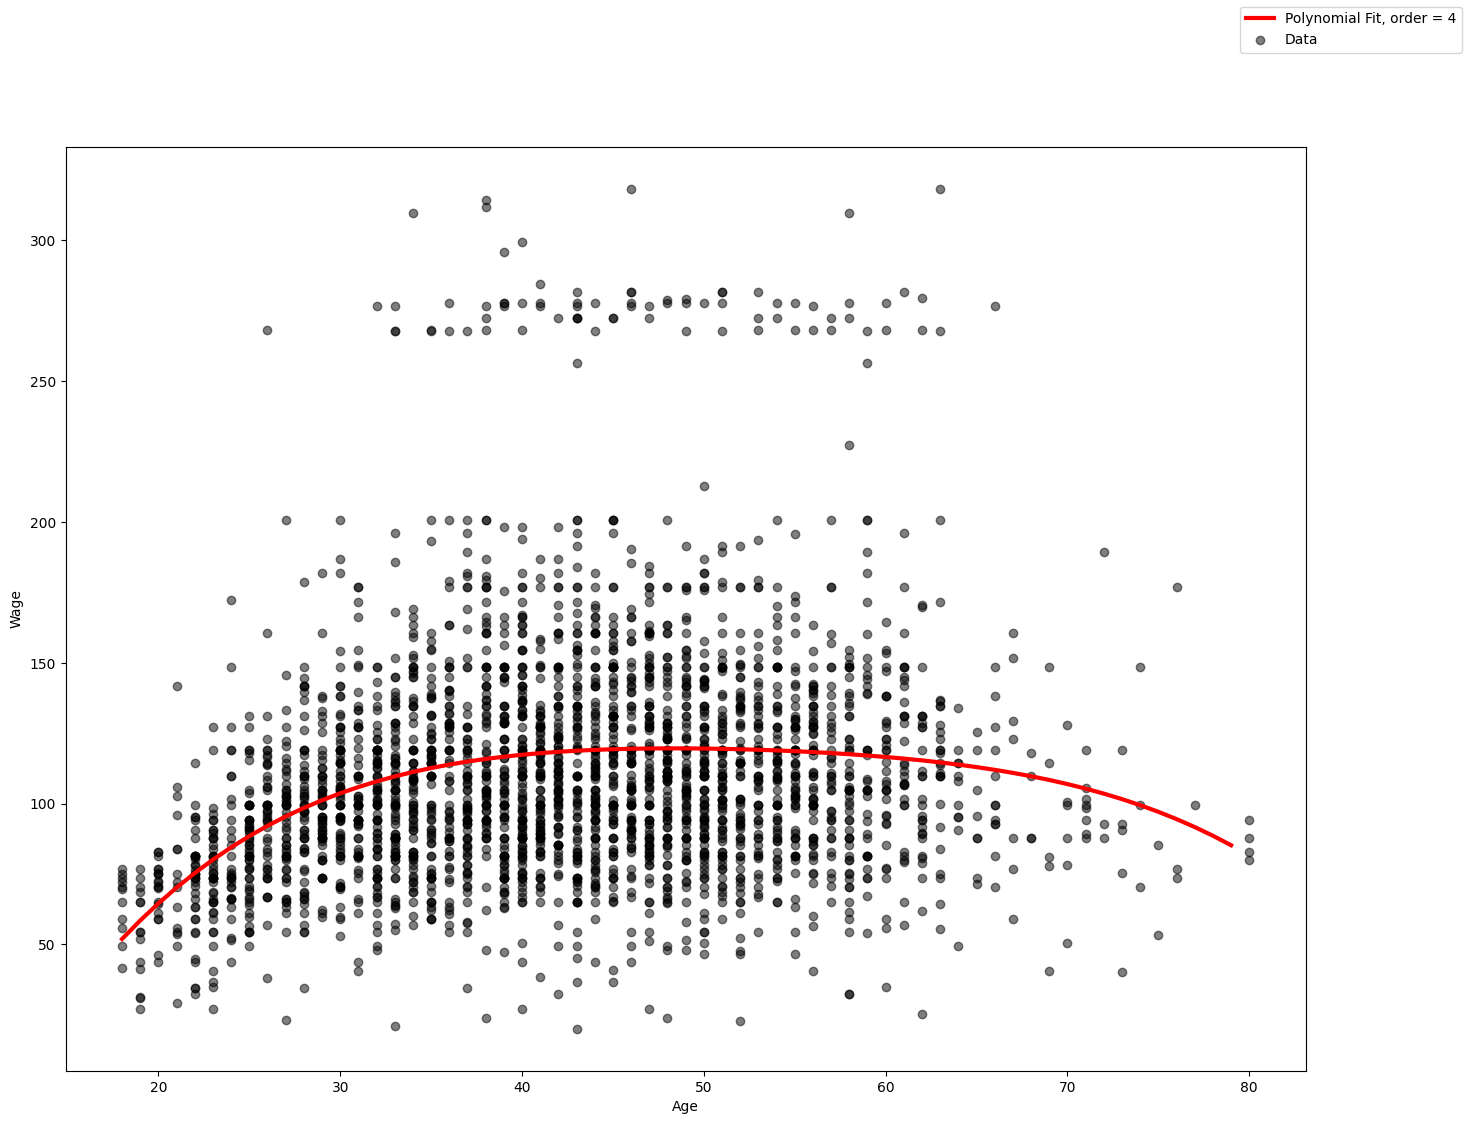

In [8]:
# plot the fit
age_grid = np.arange(Wage.age.min(), Wage.age.max()).reshape(-1, 1)
X_test = polynomial_features.fit_transform(age_grid)
y_pred = regression.predict(X_test)

fig, ax = plt.subplots(figsize = (16, 12))
ax.plot(age_grid, y_pred, color = "red", label = "Polynomial Fit, order = " + str(n_deg), linewidth=3)
ax.scatter(Wage.age, y, label = "Data", alpha=0.5, color = 'black')
ax.set_xlabel("Age")
ax.set_ylabel("Wage")
fig.legend()


### From the plot above we see that the fitted polynomial regression of degree 4 explains the data, or at least the subset comprising of individuals with wages below $250$, quite well. We shall now consider whether using a different polynomial degree might yield better results. We do this by comparing fits for all powers up to $5$ (inclusive) using an $F$-test, i.e., hypothesis testing.

In [9]:
# generate data for different polynomial degrees and fit a polynomial regression
max_degree = 5
X_data_per_degree = []
fits_per_degree = []
for degree in range(1, max_degree + 1):

    X_data_per_degree.append(PolynomialFeatures(degree=degree).fit_transform(X))
    fits_per_degree.append(sm.GLS(y, X_data_per_degree[degree-1]).fit())

In [10]:
# perform the ANOVA test
print(sm.stats.anova_lm(*fits_per_degree, type = 1))

   df_resid           ssr  df_diff        ss_diff           F        Pr(>F)
0    2998.0  5.022216e+06      0.0            NaN         NaN           NaN
1    2997.0  4.793430e+06      1.0  228786.010128  143.593107  2.363850e-32
2    2996.0  4.777674e+06      1.0   15755.693664    9.888756  1.679202e-03
3    2995.0  4.771604e+06      1.0    6070.152124    3.809813  5.104620e-02
4    2994.0  4.770322e+06      1.0    1282.563017    0.804976  3.696820e-01


### From the table above we see that the quadratic model leads to a significant improvement over the linear model. Similarly, so does the cubic model over the quadratic. For the quartic and the pentic models the improvements are not as significant, implying that a cubic model might be sufficicent to explain the relationship between age and wage, while keeping variance low. We plot the predictions of each model below.

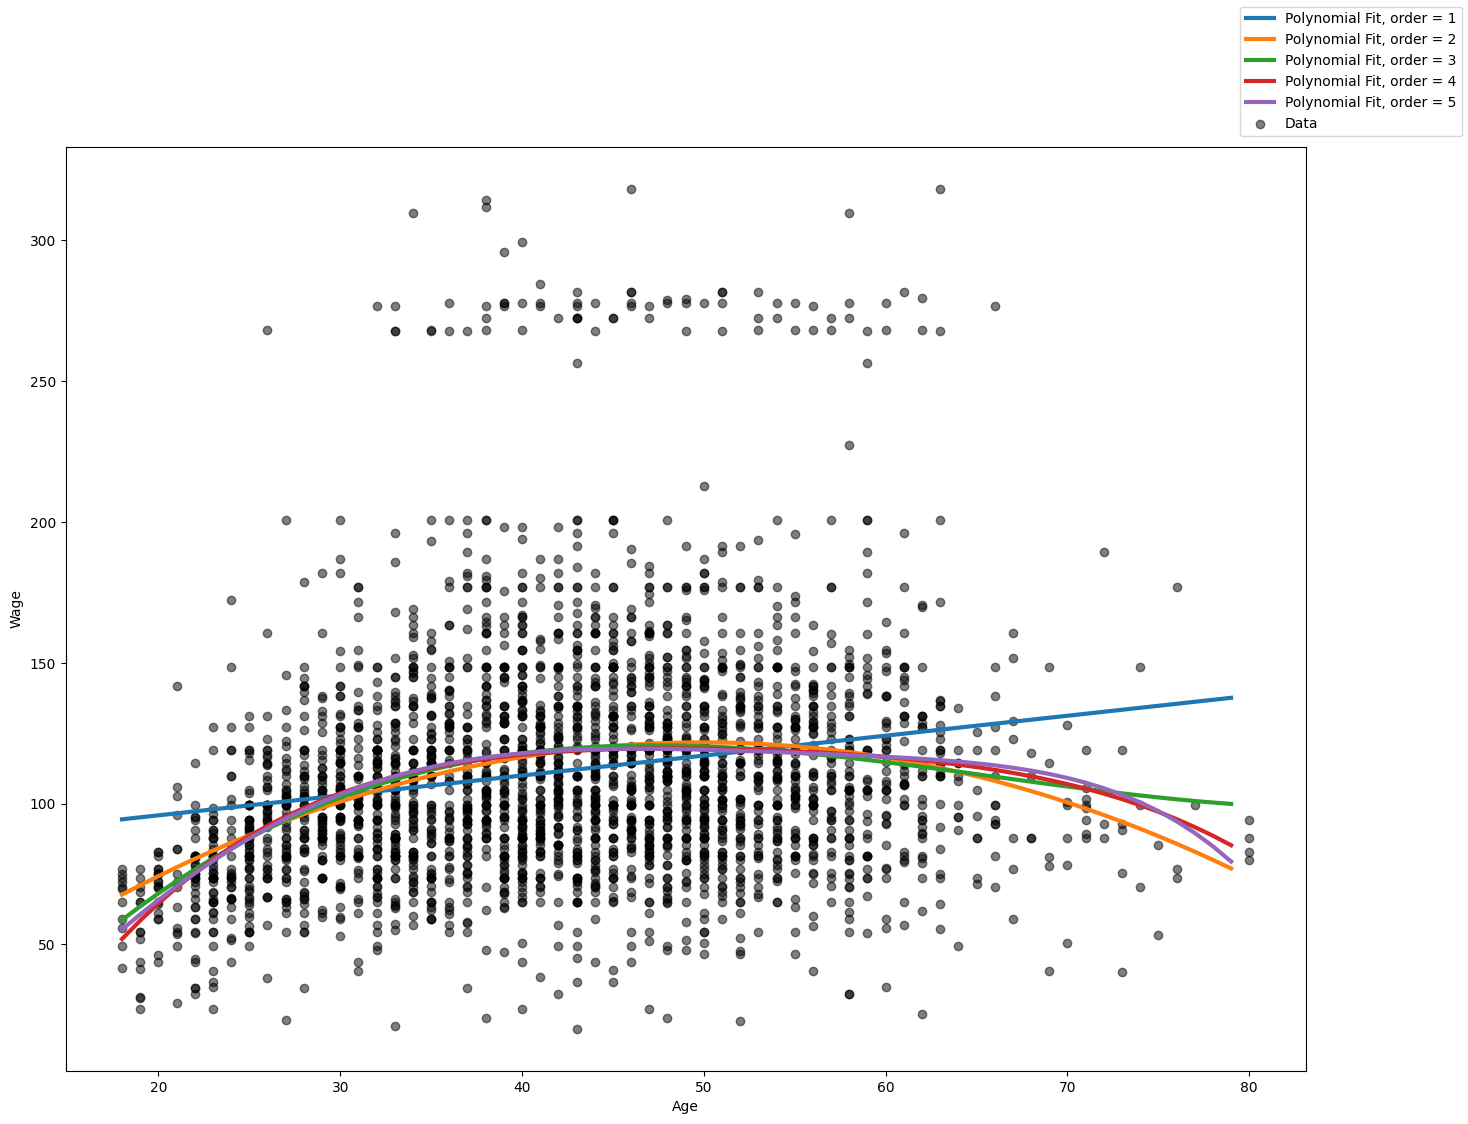

In [11]:
fig, ax = plt.subplots(figsize = (16, 12))

for degree in range(1, max_degree + 1):

    y_pred_tmp = fits_per_degree[degree-1].predict(PolynomialFeatures(degree=degree).fit_transform(age_grid))
    ax.plot(age_grid, y_pred_tmp, label = "Polynomial Fit, order = " + str(degree), linewidth = 3)

ax.scatter(Wage.age, y, label = "Data", alpha=0.5, color = 'black')
ax.set_xlabel("Age")
ax.set_ylabel("Wage")
fig.legend()

### We now consider whether we can fit a logistic regression to preedict whether a given individual earns more or less that $250k$ base on their age.

In [12]:
degree = 4
logistic_model = sm.GLM((y > 250), X_data_per_degree[degree - 1], family=sm.families.Binomial())
logistic_fit = logistic_model.fit()
print(logistic_fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2995
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -350.61
Date:                Thu, 15 Sep 2022   Deviance:                       701.22
Time:                        18:17:47   Pearson chi2:                 3.70e+03
No. Iterations:                    10   Pseudo R-squ. (CS):           0.009724
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -109.5530     47.655     -2.299      0.0

Text(0, 0.5, 'P(Wage > 250k)')

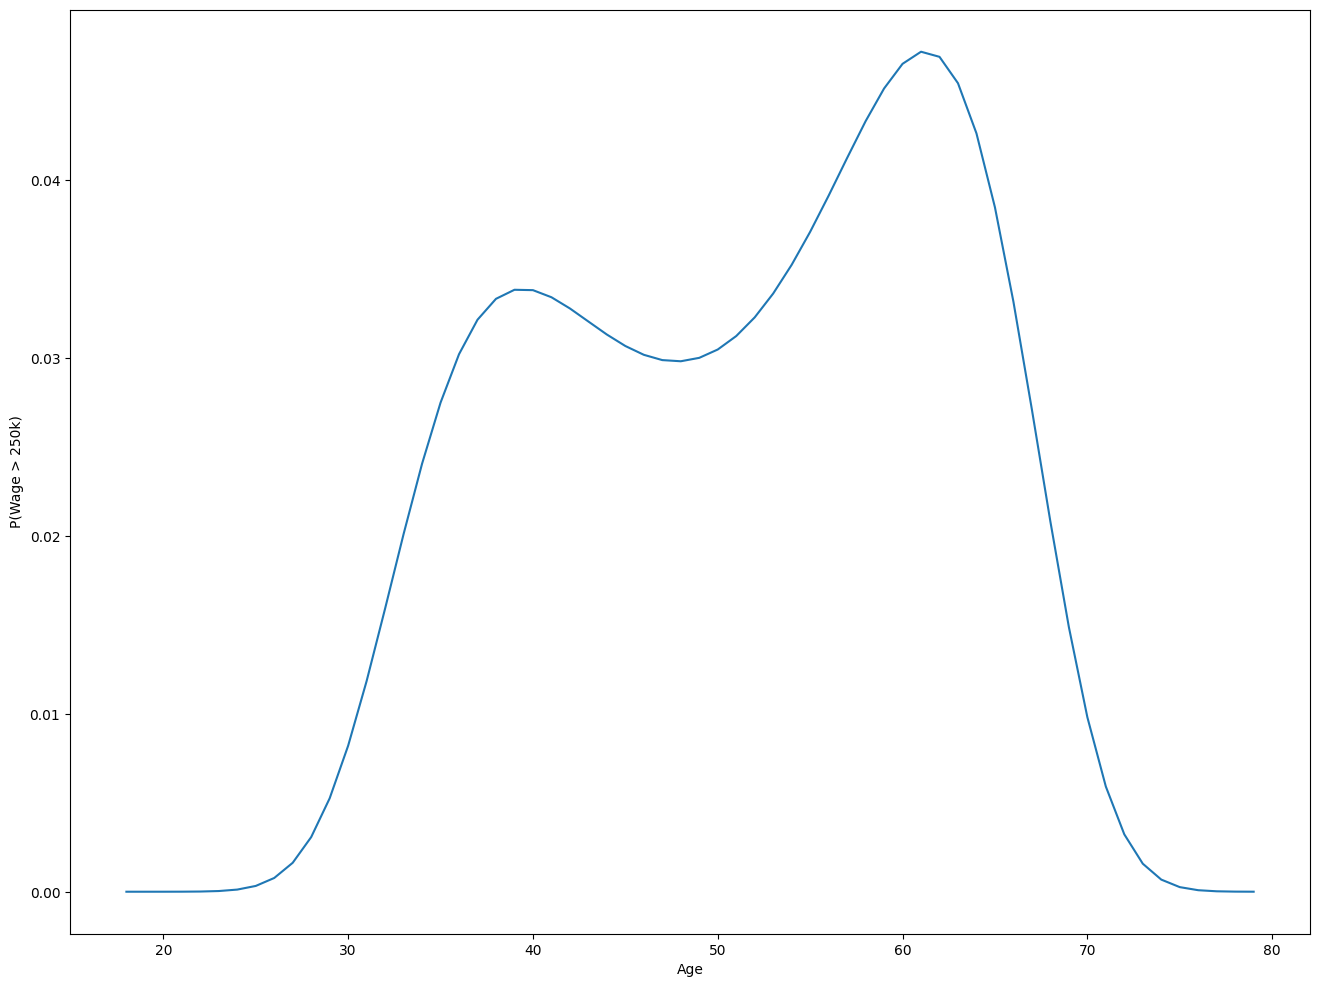

In [13]:
# plot the predicted probabilities
fig_log, ax_log = plt.subplots(figsize = (16, 12))
prob_pred = logistic_fit.predict(PolynomialFeatures(degree=degree).fit_transform(age_grid))
ax_log.plot(age_grid, prob_pred)
ax_log.set_xlabel("Age")
ax_log.set_ylabel("P(Wage > 250k)")

### As in Figure 7.1 in the book, we see that the largest probablities of having a salary greater than $250k$ is for middle-aged people, which agrees with the data.
### An alternative approach to fitting models to data is to use a step function, i.e., split the predictor range into bins, and treat each entry in a given bin as having a constant value.

In [14]:
no_bins = 10
age_cut, bins = pd.cut(Wage.age, bins=no_bins, retbins=True, right=True)
print("Chosen bin cut-off values:\n")
print(age_cut.value_counts(sort=False))

Chosen bin cut-off values:

(17.938, 24.2]    175
(24.2, 30.4]      347
(30.4, 36.6]      445
(36.6, 42.8]      542
(42.8, 49.0]      640
(49.0, 55.2]      441
(55.2, 61.4]      270
(61.4, 67.6]       96
(67.6, 73.8]       31
(73.8, 80.0]       13
Name: age, dtype: int64


In [15]:
# fit a step function model
age_cut_dummies = pd.get_dummies(age_cut)
age_cut_dummies = sm.add_constant(age_cut_dummies) # add a constant column
age_cut_dummies.drop(age_cut_dummies.columns[1], inplace=True, axis=1) # remove lowest value bin as it is unnecessary

fit_age_cut = sm.GLM(y, age_cut_dummies).fit()
print(fit_age_cut.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2990
Model Family:                Gaussian   Df Model:                            9
Link Function:               identity   Scale:                          1600.4
Method:                          IRLS   Log-Likelihood:                -15319.
Date:                Thu, 15 Sep 2022   Deviance:                   4.7853e+06
Time:                        18:17:47   Pearson chi2:                 4.79e+06
No. Iterations:                     3   Pseudo R-squ. (CS):            0.08697
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           73.3444      3.024     24.253   

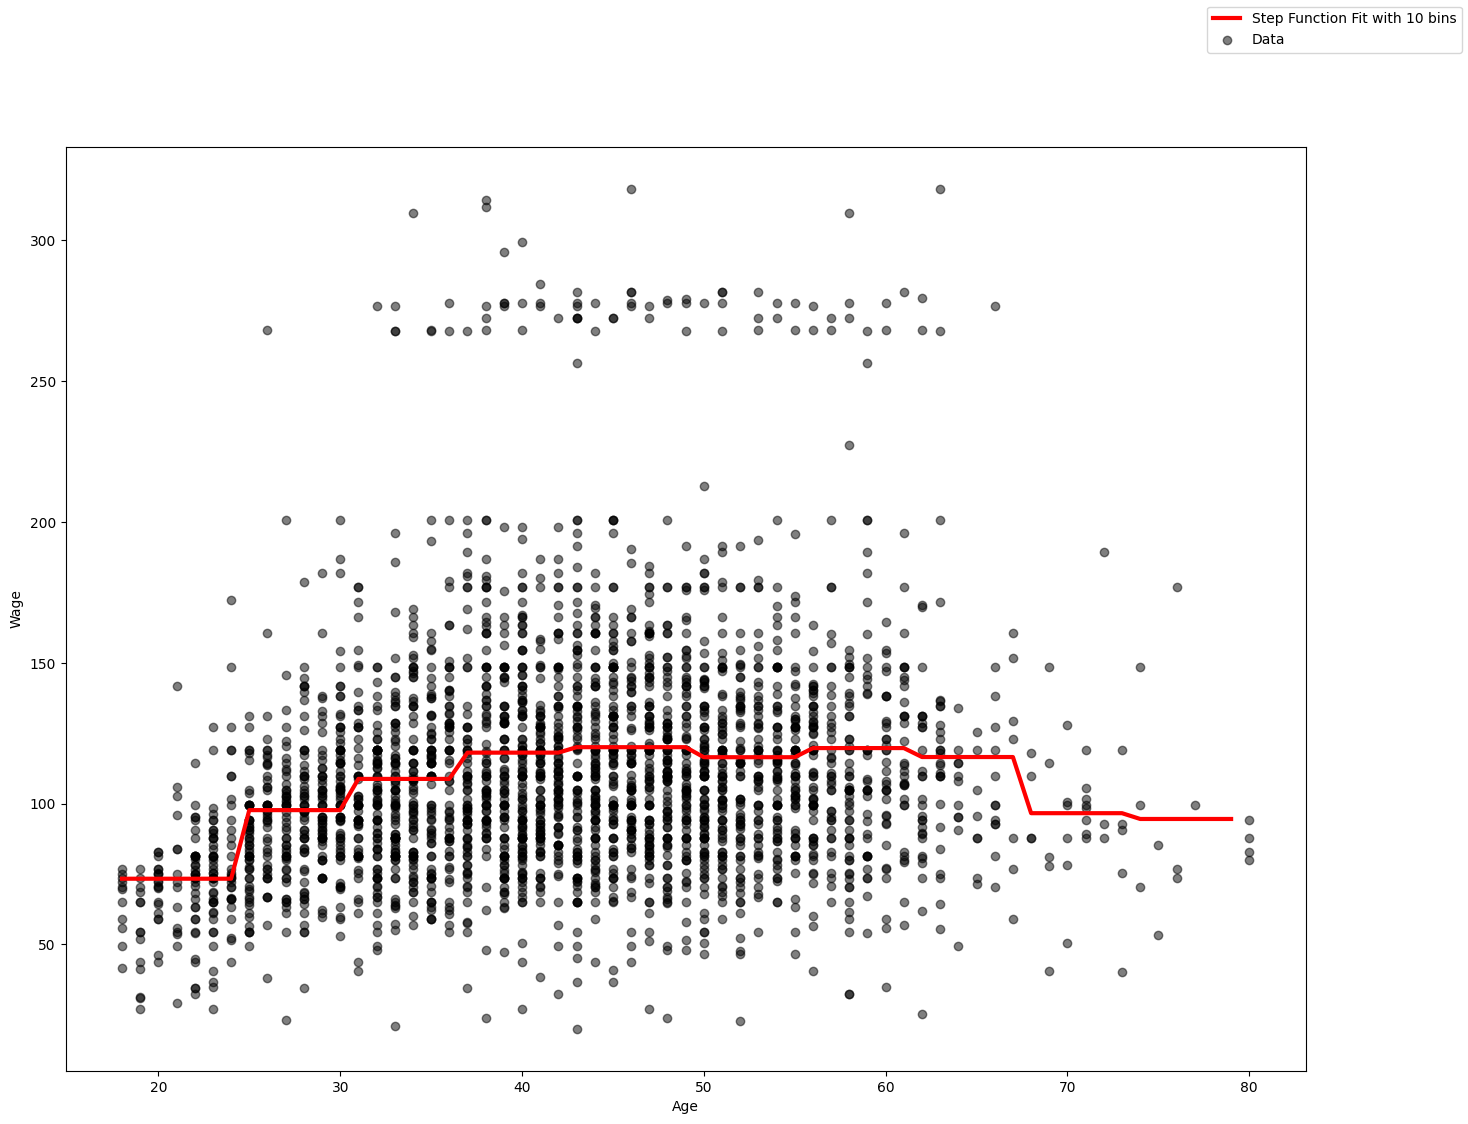

In [16]:
# plot the data
age_grid = np.arange(Wage.age.min(), Wage.age.max())
age_grid_cut = pd.cut(age_grid, bins=bins, right=True)
age_grid_cut_dummies = pd.get_dummies(age_grid_cut)
age_grid_cut_dummies = sm.add_constant(age_grid_cut_dummies) # add a constant column
age_grid_cut_dummies.drop(age_grid_cut_dummies.columns[1], inplace=True, axis=1) # remove lowest value bin as it is unnecessary
y_pred_cut = fit_age_cut.predict(age_grid_cut_dummies)

fig_cut, ax_cut = plt.subplots(figsize = (16, 12))
ax_cut.plot(age_grid, y_pred_cut, label = "Step Function Fit with " + str(no_bins) + " bins", linewidth = 3, color = 'red')
ax_cut.scatter(Wage.age, y, label = "Data", alpha=0.5, color = 'black')
ax_cut.set_xlabel("Age")
ax_cut.set_ylabel("Wage")
fig_cut.legend()

## 2. Splines
### Another option for a non-linear model is to fit a spline to the data. Specifically, we split the range of the chosen predictor into intervals, and fit a polynomial regression of degree, say $d$, for each interval, making sure that the derivatives up to the $(d-1)^\text{st}$ are continuous at the boundaries.
### We first fit a cubic spline with knots (boundaries) at $25, 40, 60$.

In [17]:
spline_basis_1 = dmatrix("bs(Wage.age, knots=(25, 40, 60), degree=3, include_intercept=False)", {"Wage.age": Wage.age}, return_type='dataframe')
spline_fit_1 = sm.GLM(Wage.wage, spline_basis_1).fit()
print(spline_fit_1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   wage   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2993
Model Family:                Gaussian   Df Model:                            6
Link Function:               identity   Scale:                          1594.0
Method:                          IRLS   Log-Likelihood:                -15314.
Date:                Thu, 15 Sep 2022   Deviance:                   4.7708e+06
Time:                        18:17:47   Pearson chi2:                 4.77e+06
No. Iterations:                     3   Pseudo R-squ. (CS):            0.09006
Covariance Type:            nonrobust                                         
                                                                             coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------

### Another option is to fix the degree of freedoms in the spline, and let the knots to be chosen automatically. Above we chose $3$ knots, amounting to $7$ degrees of freedom (including the intercept).

In [18]:
spline_basis_2 = dmatrix("bs(Wage.age, df=6, include_intercept=False)", {"Wage.age": Wage.age}, return_type='dataframe')
spline_fit_2 = sm.GLM(Wage.wage, spline_basis_2).fit()
print(spline_fit_2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   wage   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2993
Model Family:                Gaussian   Df Model:                            6
Link Function:               identity   Scale:                          1592.5
Method:                          IRLS   Log-Likelihood:                -15313.
Date:                Thu, 15 Sep 2022   Deviance:                   4.7662e+06
Time:                        18:17:47   Pearson chi2:                 4.77e+06
No. Iterations:                     3   Pseudo R-squ. (CS):            0.09101
Covariance Type:            nonrobust                                         
                                                     coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

### We can also fit a natural spline which has the additional constraint of the polynomial fits in the first and last intervals being linear.

In [19]:
spline_basis_3 = dmatrix("cr(Wage.age, df=4)", {"Wage.age": Wage.age}, return_type='dataframe')
spline_fit_3 = sm.GLM(Wage.wage, spline_basis_3).fit()
print(spline_fit_3.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   wage   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2996
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                          1596.5
Method:                          IRLS   Log-Likelihood:                -15318.
Date:                Thu, 15 Sep 2022   Deviance:                   4.7827e+06
Time:                        18:17:47   Pearson chi2:                 4.78e+06
No. Iterations:                     3   Pseudo R-squ. (CS):            0.08765
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                79.64

### We will compare all the splines by plotting them on a single plot below.

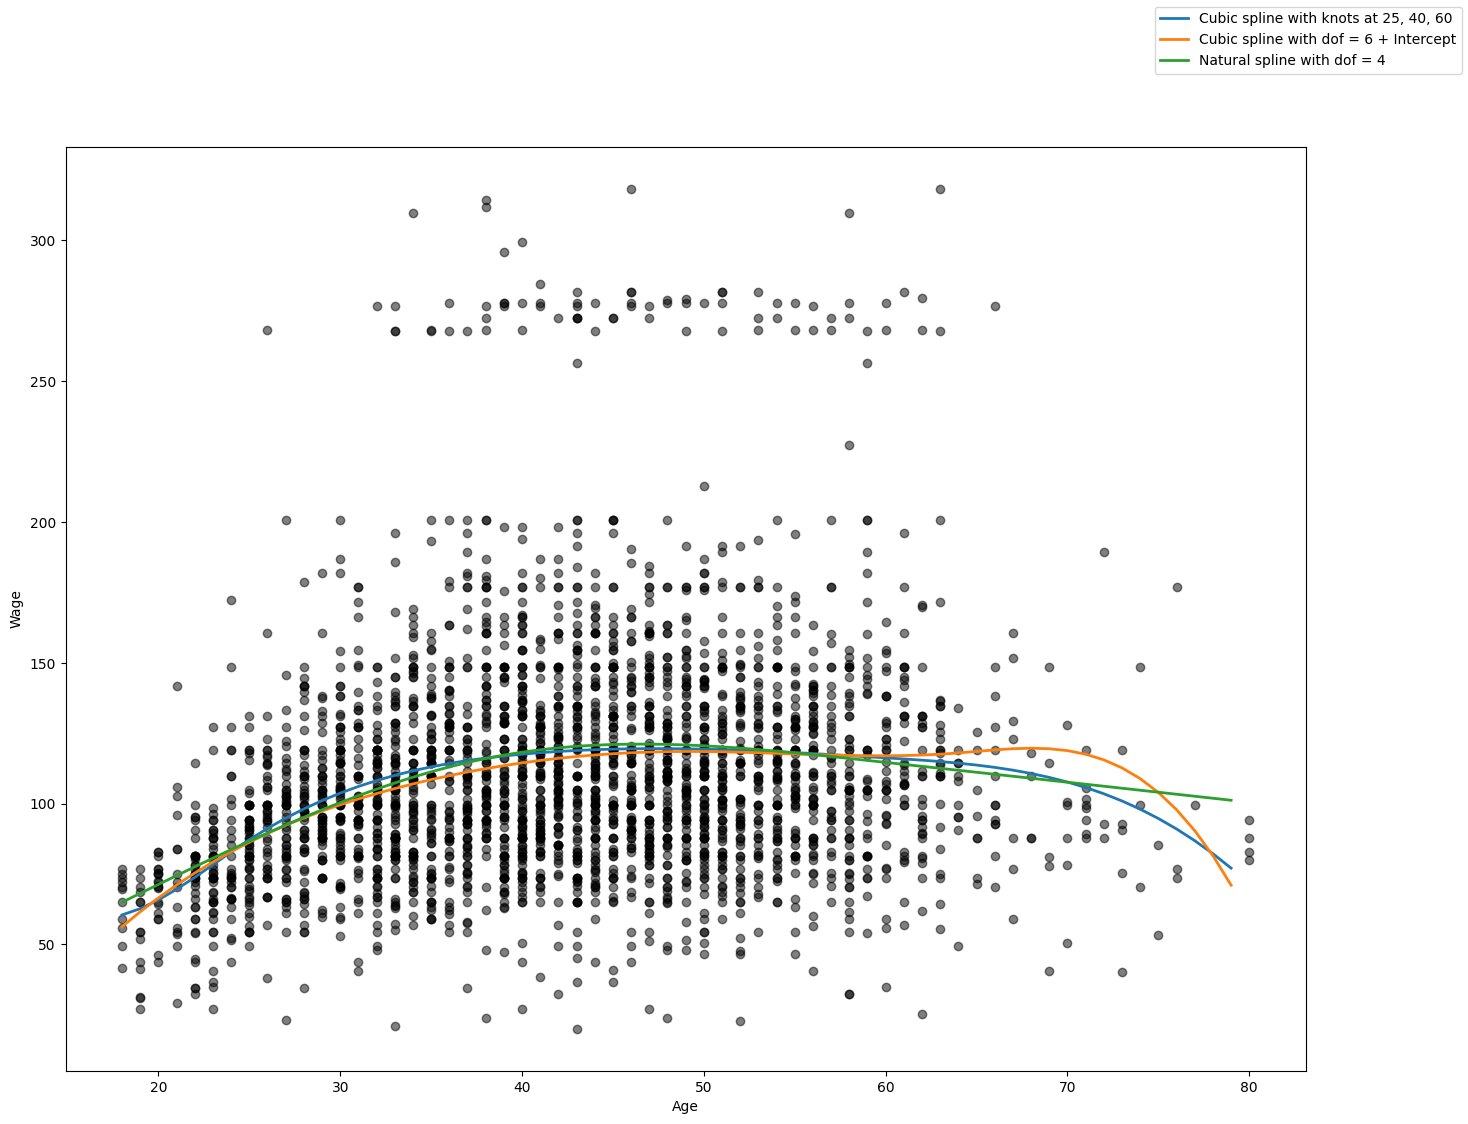

In [20]:
splines = [spline_fit_1, spline_fit_2, spline_fit_3]
predictions = []
labels = []
predictions.append(spline_fit_1.predict(dmatrix("bs(age_grid, knots=(25, 40, 60), degree=3, include_intercept=False)", {"age_grid": age_grid}, return_type='dataframe')))
labels.append("Cubic spline with knots at 25, 40, 60")
predictions.append(spline_fit_2.predict(dmatrix("bs(age_grid, df=6, include_intercept=False)", {"age_grid": age_grid}, return_type='dataframe')))
labels.append("Cubic spline with dof = 6 + Intercept")
predictions.append(spline_fit_3.predict(dmatrix("cr(age_grid, df=4)", {"age_grid": age_grid}, return_type='dataframe')))
labels.append("Natural spline with dof = 4")


fig_spline, ax_spline = plt.subplots(figsize = (16, 12))
ax_spline.scatter(Wage.age, Wage.wage, alpha = 0.5, color = 'black')
for index, pred in enumerate(predictions):
    ax_spline.plot(age_grid, pred, label = labels[index], linewidth = 2)
ax_spline.set_xlabel("Age")
ax_spline.set_ylabel("Wage")
fig_spline.legend()

### One should note that the spline with the automatically chosen knot positions seems to provide a better fit, since we do not see the unusual curvature at the end of the interval. Moreover, the natural spline is even more different at both ends, which is to be expected, and is very similar to the degree $3$ polynomial fit from above (both have the same number of degrees of freedom).

## 3. GAMs
### We now fit a generalised additive model, which just means that we apply the approaches described above to multiple predictors. We will try to predict the wage of a given individual using the 'age', 'year' and 'education' variables. For age we saw that a polynomial fit of degree $3$ is a good choice, or similarly - a natural spline with $4$ degrees of freedom. For education we employ simple linear regression on a categorical variable. For year we shall consider both a spline fit, and a simple linear fit, and use the $F$-statistic and hypothesis testing to determine which is better.

In [21]:
age_basis = dmatrix("cr(Wage.age, df=4)", {"Wage.age": Wage.age}, return_type='dataframe')
year_basis = dmatrix("cr(Wage.year, df=4)", {"Wage.year": Wage.year}, return_type='dataframe').drop(['Intercept'], axis=1)
education_dummies = pd.get_dummies(Wage.education)
education_dummies = education_dummies.drop([education_dummies.columns[0]], axis=1)

X_spline = pd.concat([age_basis, year_basis, education_dummies], axis=1)
X_linear = pd.concat([age_basis, Wage.year, education_dummies], axis=1)

In [22]:
gam_year_spline = sm.OLS(Wage.wage, X_spline).fit()
print(gam_year_spline.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     123.0
Date:                Thu, 15 Sep 2022   Prob (F-statistic):          3.06e-215
Time:                        18:17:47   Log-Likelihood:                -14933.
No. Observations:                3000   AIC:                         2.989e+04
Df Residuals:                    2989   BIC:                         2.995e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 50

In [23]:
gam_year_linear = sm.OLS(Wage.wage, X_linear).fit()
print(gam_year_linear.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     153.6
Date:                Thu, 15 Sep 2022   Prob (F-statistic):          3.79e-217
Time:                        18:17:47   Log-Likelihood:                -14934.
No. Observations:                3000   AIC:                         2.989e+04
Df Residuals:                    2991   BIC:                         2.994e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -1837.07

In [24]:
# perform the ANOVA test for the year predictor
print(sm.stats.anova_lm(gam_year_linear, gam_year_spline, type = 1))

   df_resid           ssr  df_diff      ss_diff         F    Pr(>F)
0    2991.0  3.701286e+06      0.0          NaN       NaN       NaN
1    2989.0  3.699677e+06      2.0  1609.074268  0.649992  0.522124


### We see that the $p$-value for using the a more complex (than linear) model for the year predictor is quite large, at $p\approx0.5$. Hence, we shall stick to the simpler model. We will now consider whether it is better to use a spline with more degrees of freedom for the age variable.

In [25]:
age_basis_deg_5 = dmatrix("cr(Wage.age, df=5)", {"Wage.age": Wage.age}, return_type='dataframe')

X_spline_deg_5_age = pd.concat([age_basis_deg_5, Wage.year, education_dummies], axis=1)
gam_spline_age_deg_5 = sm.OLS(Wage.wage, X_spline_deg_5_age).fit()
print(gam_spline_age_deg_5.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     136.6
Date:                Thu, 15 Sep 2022   Prob (F-statistic):          3.70e-216
Time:                        18:17:47   Log-Likelihood:                -14933.
No. Observations:                3000   AIC:                         2.989e+04
Df Residuals:                    2990   BIC:                         2.995e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -1888.57

In [26]:
# perform the ANOVA test for the age predictor
print(sm.stats.anova_lm(gam_year_linear, gam_spline_age_deg_5, type = 1))

   df_resid           ssr  df_diff     ss_diff         F    Pr(>F)
0    2991.0  3.701286e+06      0.0         NaN       NaN       NaN
1    2990.0  3.700612e+06      1.0  674.539291  0.545011  0.460422


### Once again the $p$-value is quite large for the more complex model, so we choose a natural spline with just $4$ degrees of freedom. We can also check if an even simpler model might work as well.

In [27]:
age_basis_deg_3 = dmatrix("cr(Wage.age, df=3)", {"Wage.age": Wage.age}, return_type='dataframe')

X_spline_deg_3_age = pd.concat([age_basis_deg_3, Wage.year, education_dummies], axis=1)
gam_spline_age_deg_3 = sm.OLS(Wage.wage, X_spline_deg_3_age).fit()
print(gam_spline_age_deg_3.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     173.6
Date:                Thu, 15 Sep 2022   Prob (F-statistic):          4.34e-216
Time:                        18:17:48   Log-Likelihood:                -14939.
No. Observations:                3000   AIC:                         2.989e+04
Df Residuals:                    2992   BIC:                         2.994e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -1676.76

In [28]:
# perform the ANOVA test for the age predictor
print(sm.stats.anova_lm(gam_spline_age_deg_3, gam_year_linear, gam_spline_age_deg_5, type = 1))

   df_resid           ssr  df_diff       ss_diff          F    Pr(>F)
0    2992.0  3.713875e+06      0.0           NaN        NaN       NaN
1    2991.0  3.701286e+06      1.0  12588.473444  10.171166  0.001441
2    2990.0  3.700612e+06      1.0    674.539291   0.545011  0.460422


### We find that the $p$-value between the natural spline of dof $3$ versus $4$ is very low, indicating that the more complex option is better.
### Overall, we conclude that we can model the wage of a given individual using a non-linear fit with $4$ dof for the age variable, and a linear fit for both the year and education variables.